In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import joblib

# To ignore warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the data and preprocessing
df = pd.read_csv('parking_data_2024 (1).csv')
df['Time'] = pd.to_datetime(df['Time'])

# Sort by time for proper time-series analysis
df = df.sort_values('Time')

# Extract time features
df['Hour'] = df['Time'].dt.hour
df['Day'] = df['Time'].dt.day
df['Month'] = df['Time'].dt.month
df['DayOfWeek'] = df['Time'].dt.dayofweek  # 0=Monday, 6=Sunday
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Calculate available spots
df['Available_Spots'] = (df['Free Avg %'] / 100) * df['Capacity']
df['Available_Spots'] = df['Available_Spots'].round().astype(int)

# Create cyclical time features
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

# One-hot encode categorical variables
level_dummies = pd.get_dummies(df['Level'], prefix='Level')
df = pd.concat([df, level_dummies], axis=1)

# Features for our ML model
features = ['Hour', 'Day', 'Month', 'DayOfWeek', 'IsWeekend',
            'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
            'Capacity']
features.extend(level_dummies.columns.tolist())

# Time-based split (80% train, 20% test)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

X_train = train_df[features]
y_train = train_df['Available_Spots']
X_test = test_df[features]
y_test = test_df['Available_Spots']

# Define preprocessing
numeric_features = [col for col in features if col not in level_dummies.columns]
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)],
    remainder='passthrough'
)

# Train and evaluate a Random Forest model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=50, max_depth=8, min_samples_leaf=5, random_state=42))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Random Forest - RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Save the model
joblib.dump(model, 'parking_model.joblib')

# Prediction function
def predict_availability(date, level):
    """
    Predict parking availability for a given date and garage level.
    """
    # Create time slots for the day
    date_range = pd.date_range(
        start=pd.Timestamp(date).replace(hour=0, minute=0), 
        end=pd.Timestamp(date).replace(hour=23, minute=30),
        freq='30min'
    )
    
    # Prepare prediction dataframe
    pred_data = pd.DataFrame({'Time': date_range})
    pred_data['Hour'] = pred_data['Time'].dt.hour
    pred_data['Day'] = pred_data['Time'].dt.day
    pred_data['Month'] = pred_data['Time'].dt.month
    pred_data['DayOfWeek'] = pred_data['Time'].dt.dayofweek
    pred_data['IsWeekend'] = pred_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create cyclical features
    pred_data['Hour_sin'] = np.sin(2 * np.pi * pred_data['Hour']/24)
    pred_data['Hour_cos'] = np.cos(2 * np.pi * pred_data['Hour']/24)
    pred_data['DayOfWeek_sin'] = np.sin(2 * np.pi * pred_data['DayOfWeek']/7)
    pred_data['DayOfWeek_cos'] = np.cos(2 * np.pi * pred_data['DayOfWeek']/7)
    
    # Get level-specific data
    level_data = df[df['Level'] == level]
    level_capacity = level_data['Capacity'].iloc[0]
    pred_data['Capacity'] = level_capacity
    
    # Add level dummies
    for col in level_dummies.columns:
        if col == f'Level_{level}':
            pred_data[col] = 1
        else:
            pred_data[col] = 0
    
    # Make predictions using the model
    X_pred = pred_data[features]
    pred_data['Available_Spots'] = model.predict(X_pred).round().astype(int)
    
    # Ensure predictions are within bounds
    pred_data['Available_Spots'] = pred_data['Available_Spots'].clip(0, level_capacity)
    pred_data['Occupancy_Percentage'] = 100 - (pred_data['Available_Spots'] / level_capacity * 100)
    
    return pred_data[['Time', 'Available_Spots', 'Occupancy_Percentage']]

# Interactive prediction function
def predict_parking():
    """Interactive function to predict parking availability"""
    date_input = input("Enter date (YYYY-MM-DD) or 'today'/'tomorrow': ")
    
    if date_input.lower() == 'today':
        date = pd.Timestamp.now().date()
    elif date_input.lower() == 'tomorrow':
        date = pd.Timestamp.now().date() + pd.Timedelta(days=1)
    else:
        try:
            date = pd.to_datetime(date_input).date()
        except:
            print("Invalid date format. Using tomorrow's date.")
            date = pd.Timestamp.now().date() + pd.Timedelta(days=1)
    
    unique_levels = df['Level'].unique()
    print(f"Available levels: {', '.join(unique_levels)}")
    level_input = input(f"Enter level (default: {unique_levels[0]}): ") or unique_levels[0]
    
    # Make prediction
    try:
        predictions = predict_availability(date, level_input)
        level_capacity = df[df['Level'] == level_input]['Capacity'].iloc[0]
        
        # Display results
        print(f"\nPredictions for {date} (Level {level_input}):")
        print(predictions[['Time', 'Available_Spots', 'Occupancy_Percentage']].head())
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(predictions['Time'], predictions['Available_Spots'], 'b-', marker='o', alpha=0.7)
        plt.axhline(level_capacity, color='r', linestyle='--', label='Total Capacity')
        plt.fill_between(predictions['Time'], 0, predictions['Available_Spots'], alpha=0.3, color='green')
        plt.title(f'Forecasted Parking Availability for {date} (Level {level_input})')
        plt.xlabel('Time of Day')
        plt.ylabel('Available Parking Spots')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.legend()
        plt.show()
        
        return predictions
    except Exception as e:
        print(f"Error making prediction: {e}")

print("\nRun predict_parking() to make interactive predictions")

Random Forest - RMSE: 33.97, R²: 0.86

Run predict_parking() to make interactive predictions


Available levels: Lake Street Garage.Level 4, Lake Street Garage.Level 1 - 10 Minutes, Lake Street Garage.State Vehicles, Lake Street Garage.Level 1 ADA, Lake Street Garage.Level 1.Zone 2, Lake Street Garage.Level 1.Zone 1, Lake Street Garage.Level 1.Zone 3, Lake Street Garage.Level 1, Lake Street Garage.Level 2 ADA, Lake Street Garage.Level 2, Lake Street Garage.Level 3 ADA, Lake Street Garage.Level 3, Lake Street Garage.Level 1.EV Stations

Predictions for 2025-04-19 (Level Lake Street Garage.Level 1):
                 Time  Available_Spots  Occupancy_Percentage
0 2025-04-19 00:00:00              111             13.953488
1 2025-04-19 00:30:00              111             13.953488
2 2025-04-19 01:00:00              111             13.953488
3 2025-04-19 01:30:00              111             13.953488
4 2025-04-19 02:00:00              111             13.953488


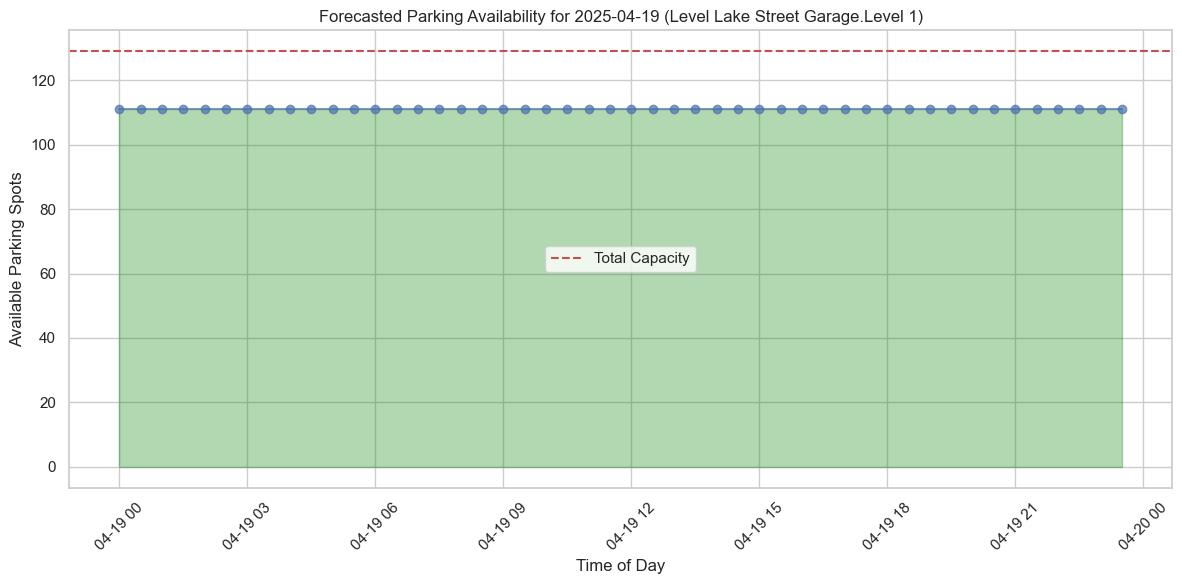

,Time,Available_Spots,Occupancy_Percentage
0,2025-04-19 00:00:00,111,13.953488
1,2025-04-19 00:30:00,111,13.953488
2,2025-04-19 01:00:00,111,13.953488
3,2025-04-19 01:30:00,111,13.953488
4,2025-04-19 02:00:00,111,13.953488
5,2025-04-19 02:30:00,111,13.953488
6,2025-04-19 03:00:00,111,13.953488
7,2025-04-19 03:30:00,111,13.953488
8,2025-04-19 04:00:00,111,13.953488
9,2025-04-19 04:30:00,111,13.953488


In [6]:
predict_parking()